In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences

In [2]:
# Import tweets and sentiment data

dataset = pd.read_excel('sample_tweets.xlsx')
dataset = dataset[dataset['Sentiment'] != 'Neutral']

tweets = dataset['SentimentText'].values
sent = dataset['Sentiment'].values

In [3]:
print(tweets.shape, sent.shape)

(7108,) (7108,)


In [4]:
tweets[0]

"#gstnfailed @nsitharaman .. Such a bold step.. Made by extending 3 days.. Now v know.. V should never vote & give majority to @BJP4India @PMOIndia .. Such a foolish step.. Really saddened to know.. Dat u don't understand d stress. of GST professionals.."

In [5]:
# Create emedding_vector for each word from Glove

f = open("glove.6B.50d.txt", encoding="utf-8")
glove_emb = {}
for line in f:
    arr = line.split()
    word = arr[0]
    vect = np.asarray(arr[1:], dtype="float")
    glove_emb[word] = vect

f.close()
print(glove_emb['car'])

[ 0.47685  -0.084552  1.4641    0.047017  0.14686   0.5082   -1.2228
 -0.22607   0.19306  -0.29756   0.20599  -0.71284  -1.6288    0.17096
  0.74797  -0.061943 -0.65766   1.3786   -0.68043  -1.7551    0.58319
  0.25157  -1.2114    0.81343   0.094825 -1.6819   -0.64498   0.6322
  1.1211    0.16112   2.5379    0.24852  -0.26816   0.32818   1.2916
  0.23548   0.61465  -0.1344   -0.13237   0.27398  -0.11821   0.1354
  0.074306 -0.61951   0.45472  -0.30318  -0.21883  -0.56054   1.1177
 -0.36595 ]


In [6]:
re = RegexpTokenizer("[a-zA-Z]+")
sw = stopwords.words("english")

In [7]:
unique_vocab = {}
ind = 1;
weight = []
X = tweets
X_train = np.zeros((X.shape[0], 50))

for i in range(X.shape[0]):
    words = re.tokenize(X[i])
    words = [w for w in words if w not in sw and len(w) > 2 and w in glove_emb]
    
    for j in range(min(len(words), 50)):
        if words[j].lower() in unique_vocab:
            X_train[i][j] = unique_vocab[words[j].lower()]
            
        else:
            weight.append(glove_emb[words[j]])
            X_train[i][j] = ind
            unique_vocab[words[j].lower()] = ind
            ind += 1

In [8]:
X_train[0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  2., 11.,  5.,
       12., 13., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [9]:
wt_mat = [np.zeros((50,))] + weight
wt_mat = np.array(wt_mat)

In [10]:
print(wt_mat.shape)

(3679, 50)


In [11]:
le=LabelEncoder()
Y = le.fit_transform(sent)

In [12]:
print(X_train[1], Y[1])
print(X_train.shape, Y.shape)

[15. 16. 17. 18. 19. 20. 21. 15. 22.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 0
(7108, 50) (7108,)


In [15]:
# Create LSTM model

model = Sequential()
model.add(Embedding(3679, 50, mask_zero=True, weights=[wt_mat], input_length=50, trainable=False))
model.add(LSTM(32, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            183950    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            10624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 202,927
Trainable params: 18,977
Non-trainable params: 183,950
___________________________________________

In [16]:
# Train model

hist = model.fit(X_train, Y, validation_split=0.2, epochs=16, batch_size=32)

Epoch 1/16
178/178 [==============================] - 8s 47ms/step - loss: 0.2483 - acc: 0.9316 - val_loss: 0.2851 - val_acc: 0.9100
Epoch 2/16
178/178 [==============================] - 8s 46ms/step - loss: 0.1930 - acc: 0.9330 - val_loss: 0.3026 - val_acc: 0.9100
Epoch 3/16
178/178 [==============================] - 8s 45ms/step - loss: 0.1714 - acc: 0.9344 - val_loss: 0.3071 - val_acc: 0.9156
Epoch 4/16
178/178 [==============================] - 8s 44ms/step - loss: 0.1642 - acc: 0.9388 - val_loss: 0.3031 - val_acc: 0.9128
Epoch 5/16
178/178 [==============================] - 8s 44ms/step - loss: 0.1522 - acc: 0.9413 - val_loss: 0.3366 - val_acc: 0.9198
Epoch 6/16
178/178 [==============================] - 8s 46ms/step - loss: 0.1455 - acc: 0.9421 - val_loss: 0.3319 - val_acc: 0.9177
Epoch 7/16
178/178 [==============================] - 9s 50ms/step - loss: 0.1346 - acc: 0.9455 - val_loss: 0.4399 - val_acc: 0.9212
Epoch 8/16
178/178 [==============================] - 8s 45ms/step - 

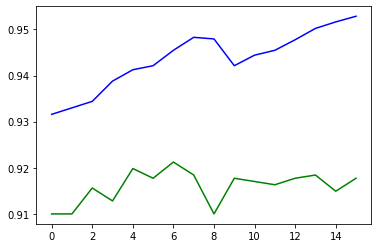

In [17]:
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='g')
plt.show()

In [19]:
y_pred = model.predict_classes(X_train)

In [20]:
print('confusion matrix')
print(confusion_matrix(Y, y_pred))

confusion matrix
[[6582   17]
 [ 353  156]]
